Data type of inter_arrival_time: object
Number of NaN values after conversion: 0
Min: 3.0, Max: 4218542391774.0

TCP Protocol:
  Number of packets: 809875
  Mean inter-arrival time: 24568.71 ms
  Median inter-arrival time: 563.00 ms
  Min: 3.00 ms, Max: 496117.00 ms


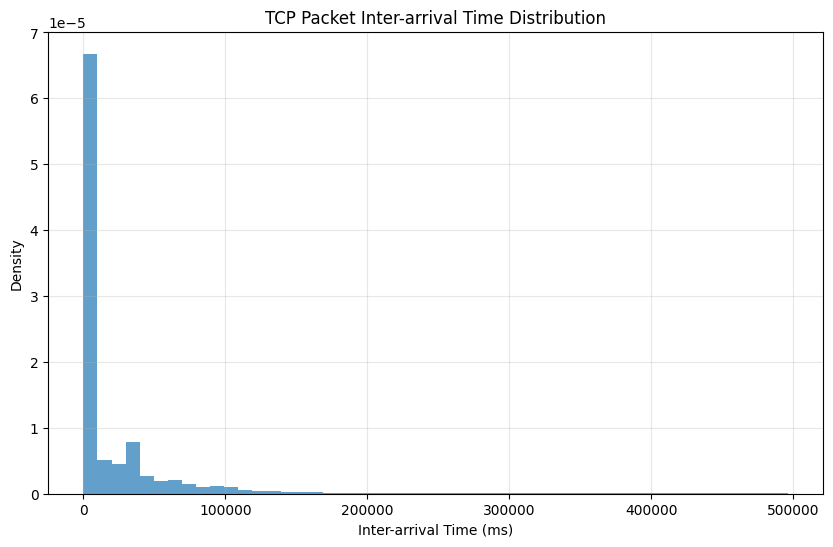

In [12]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Load your processed data
df = pd.read_csv('data/processed_data_Zepeto.csv')

# First, check the datatype of inter_arrival_time
print(f"Data type of inter_arrival_time: {df['inter_arrival_time'].dtype}")

# Convert inter_arrival_time to numeric values
# First, try to directly convert
try:
    df['inter_arrival_ms'] = pd.to_numeric(df['inter_arrival_time'])
except:
    # If that fails, it's likely in a string format like '0 days 00:00:00.169000'
    # Parse the string to extract seconds
    def convert_timedelta_to_ms(td_str):
        if isinstance(td_str, (int, float)):
            return float(td_str)
        try:
            parts = td_str.split()
            if len(parts) >= 3:  # Format like '0 days 00:00:00.169000'
                days = int(parts[0])
                time_parts = parts[2].split(':')
                hours = int(time_parts[0])
                minutes = int(time_parts[1])
                seconds = float(time_parts[2])
                
                total_ms = (days*86400 + hours*3600 + minutes*60 + seconds) * 1000
                return total_ms
            else:
                # Try direct conversion as fallback
                return float(td_str)
        except:
            # Return NaN for values we can't parse
            return np.nan
    
    df['inter_arrival_ms'] = df['inter_arrival_time'].apply(convert_timedelta_to_ms)

# Check for NaN values after conversion
print(f"Number of NaN values after conversion: {df['inter_arrival_ms'].isna().sum()}")
print(f"Min: {df['inter_arrival_ms'].min()}, Max: {df['inter_arrival_ms'].max()}")

# Focus on TCP protocol
tcp_df = df[df['Protocol'] == 'TCP']
tcp_data = tcp_df['inter_arrival_ms'].dropna().values

# Filter out extreme values (keep below 95th percentile)
threshold = np.percentile(tcp_data, 95)
filtered_tcp = tcp_data[tcp_data < threshold]

print(f"\nTCP Protocol:")
print(f"  Number of packets: {len(filtered_tcp)}")
print(f"  Mean inter-arrival time: {np.mean(filtered_tcp):.2f} ms")
print(f"  Median inter-arrival time: {np.median(filtered_tcp):.2f} ms")
print(f"  Min: {np.min(filtered_tcp):.2f} ms, Max: {np.max(filtered_tcp):.2f} ms")

# Plot histogram of data
plt.figure(figsize=(10, 6))
plt.hist(filtered_tcp, bins=50, alpha=0.7, density=True)
plt.title("TCP Packet Inter-arrival Time Distribution")
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)

Output()

Finished [100%]: Average Loss = 8.0274e+06
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

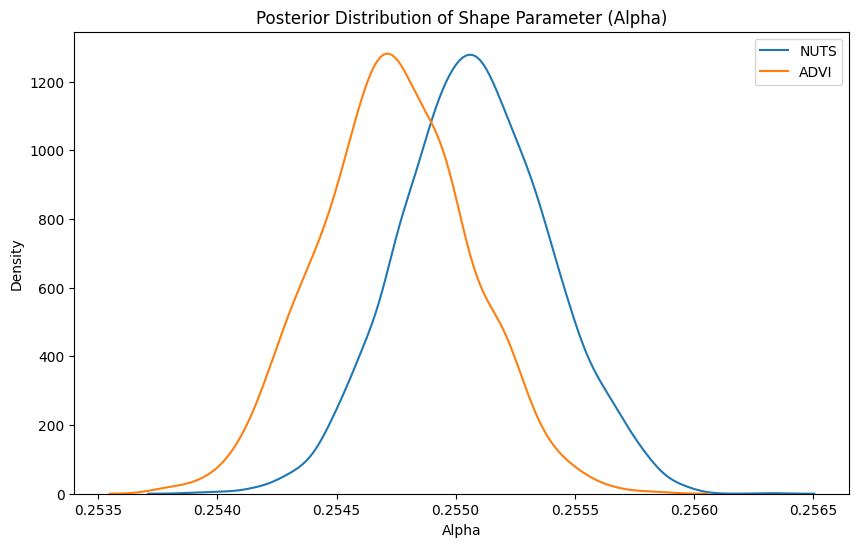

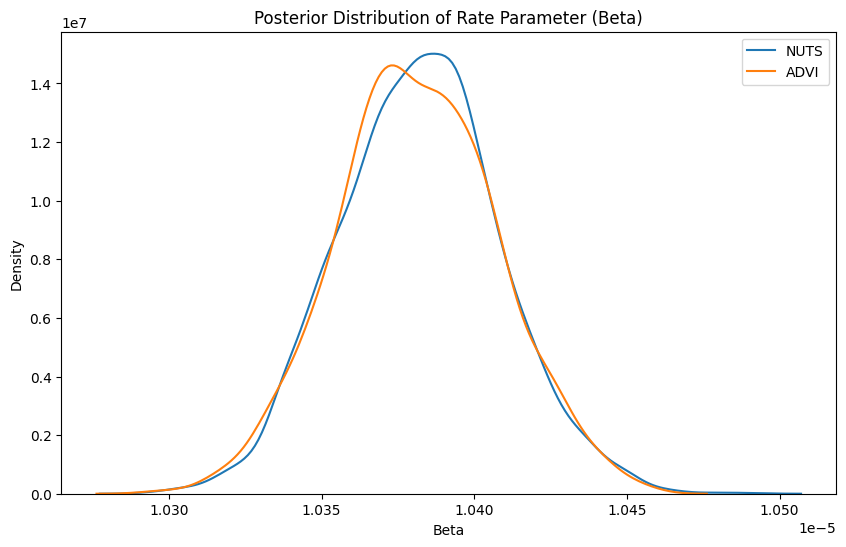

In [17]:
with pm.Model() as gamma_model:
    # Prior distributions
    alpha = pm.Exponential("alpha", 0.1)
    beta = pm.Exponential("beta", 0.1)
    
    y = pm.Gamma("y", alpha=alpha, beta=beta, observed=filtered_tcp)
    mean_field = pm.fit(obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    trace = pm.sample()

# Sample from the posterior
approx_sample = mean_field.sample(1000)

# Plot posterior distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(trace.posterior["alpha"].values.flatten(), label="NUTS")
sns.kdeplot(approx_sample.posterior["alpha"].values.flatten(), label="ADVI")
plt.title("Posterior Distribution of Shape Parameter (Alpha)")
plt.xlabel("Alpha")
plt.ylabel("Density")
plt.legend()

plt.figure(figsize=(10, 6))
sns.kdeplot(trace.posterior["beta"].values.flatten(), label="NUTS")
sns.kdeplot(approx_sample.posterior["beta"].values.flatten(), label="ADVI")
plt.title("Posterior Distribution of Rate Parameter (Beta)")
plt.xlabel("Beta")
plt.ylabel("Density")
plt.legend()

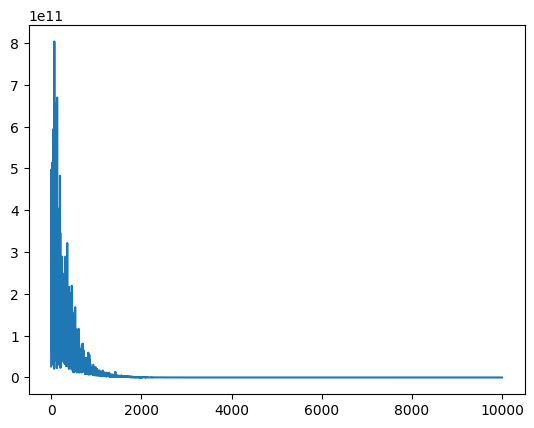

In [18]:
plt.plot(mean_field.hist)


Posterior Means:
  NUTS: alpha = 0.2551, beta = 0.0000
  ADVI: alpha = 0.2547, beta = 0.0000

KL Divergence (lower is better):
  Empirical vs Gamma (NUTS): 0.187992
  Empirical vs Gamma (ADVI): 0.187826
  Better fit: ADVI


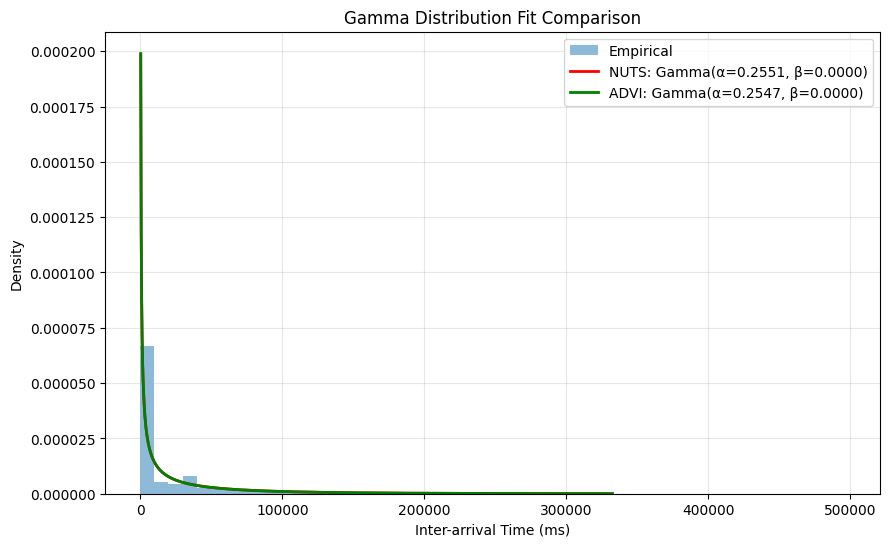

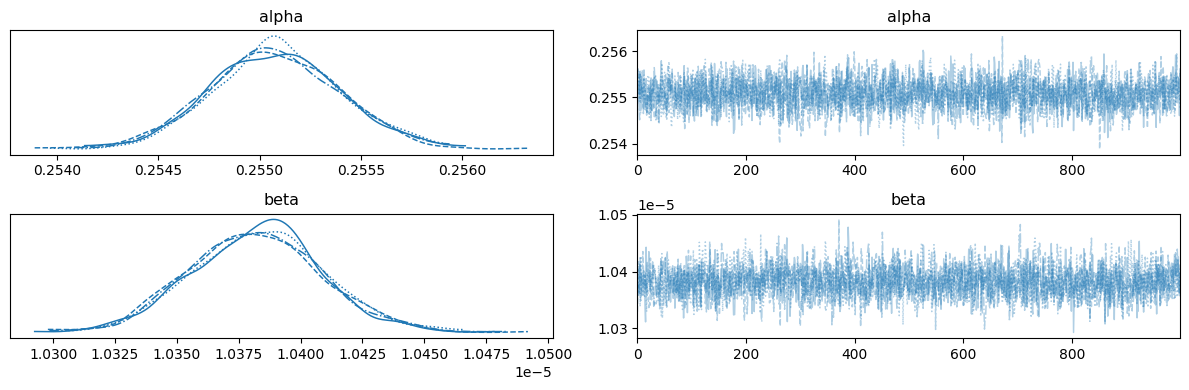

In [ ]:
# Calculate KL Divergence for Gamma distribution
# Get mean posterior values
alpha_nuts = float(trace.posterior["alpha"].mean())
beta_nuts = float(trace.posterior["beta"].mean())
alpha_advi = float(approx_sample.posterior["alpha"].mean())
beta_advi = float(approx_sample.posterior["beta"].mean())
print(f"\nPosterior Means:")
print(f"  NUTS: alpha = {alpha_nuts:.4f}, beta = {beta_nuts:.4f}")
print(f"  ADVI: alpha = {alpha_advi:.4f}, beta = {beta_advi:.4f}")

# Create evaluation points
x = np.linspace(0, np.percentile(filtered_tcp, 99), 1000)
try:
    gamma_nuts = stats.gamma.pdf(x, a=alpha_nuts, scale=1/beta_nuts)
    valid_nuts = True
except:
    print("Error calculating NUTS PDF - using fallback")
    valid_nuts = False    
try:
    gamma_advi = stats.gamma.pdf(x, a=alpha_advi, scale=1/beta_advi)
    valid_advi = True
except:
    print("Error calculating ADVI PDF - using fallback")
    valid_advi = False

# Plot comparison (only plot valid distributions)
plt.figure(figsize=(10, 6))
plt.hist(filtered_tcp, bins=50, density=True, alpha=0.5, label='Empirical')
if valid_nuts:
    plt.plot(x, gamma_nuts, 'r-', linewidth=2, label=f'NUTS: Gamma(α={alpha_nuts:.4f}, β={beta_nuts:.4f})')
if valid_advi:
    plt.plot(x, gamma_advi, 'g-', linewidth=2, label=f'ADVI: Gamma(α={alpha_advi:.4f}, β={beta_advi:.4f})')

plt.title("Gamma Distribution Fit Comparison")
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("gamma_comparison.png")

# Calculate KL divergence only if distributions are valid
hist, bin_edges = np.histogram(filtered_tcp, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
print("\nKL Divergence (lower is better):")
def calculate_kl(hist, theoretical_pdf):
    # Add epsilon to avoid zeros
    epsilon = 1e-10
    p = hist + epsilon
    q = theoretical_pdf + epsilon
    # Normalize to ensure proper probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)
    # KL divergence
    valid_indices = (p > 0) & (q > 0) & np.isfinite(p) & np.isfinite(q)
    if np.sum(valid_indices) == 0:
        return float('nan')
    p_valid = p[valid_indices]
    q_valid = q[valid_indices]
    return np.sum(p_valid * np.log(p_valid / q_valid))

if valid_nuts:
    gamma_nuts_prob = stats.gamma.pdf(bin_centers, a=alpha_nuts, scale=1/beta_nuts)
    kl_nuts = calculate_kl(hist, gamma_nuts_prob)
    print(f"  Empirical vs Gamma (NUTS): {kl_nuts:.6f}")
else:
    print("  NUTS KL calculation failed")
    kl_nuts = float('inf')

if valid_advi:
    gamma_advi_prob = stats.gamma.pdf(bin_centers, a=alpha_advi, scale=1/beta_advi)
    kl_advi = calculate_kl(hist, gamma_advi_prob)
    print(f"  Empirical vs Gamma (ADVI): {kl_advi:.6f}")
else:
    print("  ADVI KL calculation failed")
    kl_advi = float('inf')

# Determine which method is better
if np.isfinite(kl_nuts) and np.isfinite(kl_advi):
    better = "NUTS" if kl_nuts < kl_advi else "ADVI"
    print(f"  Better fit: {better}")
elif np.isfinite(kl_nuts):
    print("  Better fit: NUTS (ADVI calculation failed)")
elif np.isfinite(kl_advi):
    print("  Better fit: ADVI (NUTS calculation failed)")
else:
    print("  Both KL calculations failed")

az.plot_trace(trace)
plt.tight_layout()

Output()

Finished [100%]: Average Loss = 1.0278e+07
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

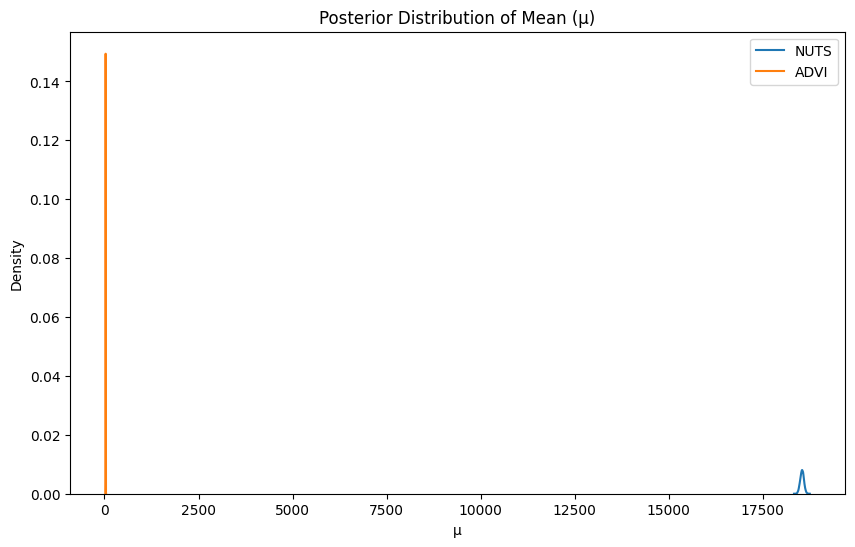

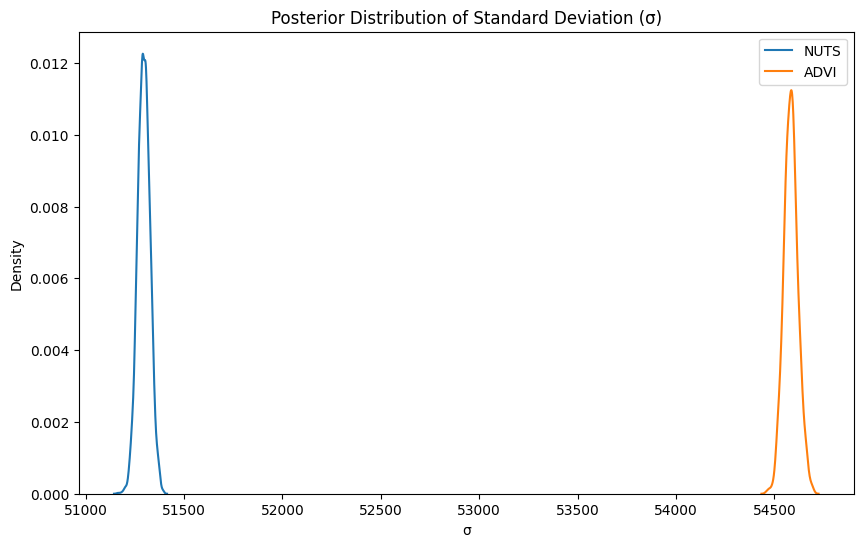

In [23]:
# Gaussian
with pm.Model() as normal_model:
    # Prior distributions
    mu = pm.Normal("mu", mu=0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=100)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=filtered_tcp)
    # mean_field = pm.fit()
    mean_field = pm.fit(obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    trace = pm.sample()

# Sample from the posterior
approx_sample = mean_field.sample(1000)

# Plot posterior distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(trace.posterior["mu"].values.flatten(), label="NUTS")
sns.kdeplot(approx_sample.posterior["mu"].values.flatten(), label="ADVI")
plt.title("Posterior Distribution of Mean (μ)")
plt.xlabel("μ")
plt.ylabel("Density")
plt.legend()

plt.figure(figsize=(10, 6))
sns.kdeplot(trace.posterior["sigma"].values.flatten(), label="NUTS")
sns.kdeplot(approx_sample.posterior["sigma"].values.flatten(), label="ADVI")
plt.title("Posterior Distribution of Standard Deviation (σ)")
plt.xlabel("σ")
plt.ylabel("Density")
plt.legend()


Posterior Means:
  NUTS: mu = 18543.2245, sigma = 51295.7727
  ADVI: mu = 2.4699, sigma = 1229.5533

KL Divergence (lower is better):
  Empirical vs Normal (NUTS): 1.008030
  Empirical vs Normal (ADVI): 0.813141
  Better fit: ADVI


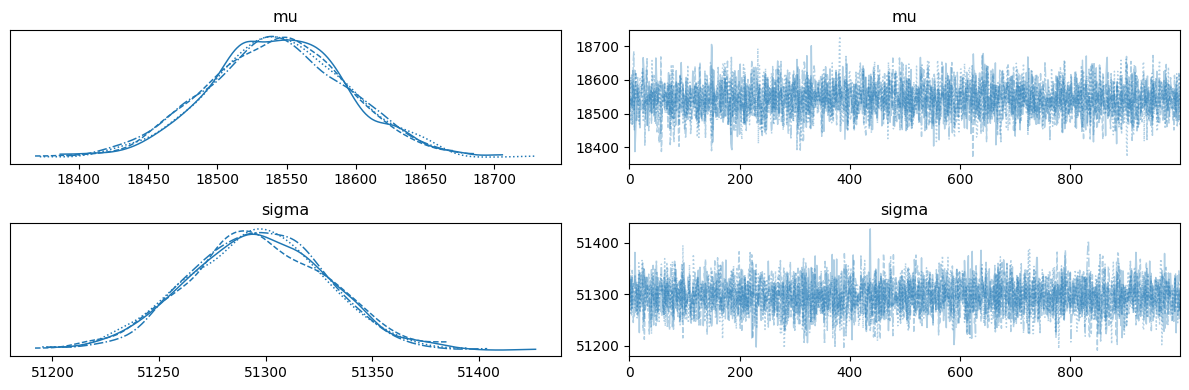

In [22]:
# Calculate KL Divergence with Normal distribution
# Get mean posterior values
mu_nuts = float(trace.posterior["mu"].mean())
sigma_nuts = float(trace.posterior["sigma"].mean())
mu_advi = float(approx_sample.posterior["mu"].mean())
sigma_advi = float(approx_sample.posterior["sigma"].mean())

print(f"\nPosterior Means:")
print(f"  NUTS: mu = {mu_nuts:.4f}, sigma = {sigma_nuts:.4f}")
print(f"  ADVI: mu = {mu_advi:.4f}, sigma = {sigma_advi:.4f}")

# Create evaluation points
x = np.linspace(0, np.percentile(filtered_tcp, 99), 1000)
try:
    normal_nuts = stats.norm.pdf(x, loc=mu_nuts, scale=sigma_nuts)
    valid_nuts = True
except:
    print("Error calculating NUTS PDF - using fallback")
    valid_nuts = False
try:
    normal_advi = stats.norm.pdf(x, loc=mu_advi, scale=sigma_advi)
    valid_advi = True
except:
    print("Error calculating ADVI PDF - using fallback")
    valid_advi = False

# Plot comparison (only plot valid distributions)
plt.figure(figsize=(10, 6))
plt.hist(filtered_tcp, bins=50, density=True, alpha=0.5, label='Empirical')
if valid_nuts:
    plt.plot(x, normal_nuts, 'r-', linewidth=2, label=f'NUTS: Normal(μ={mu_nuts:.4f}, σ={sigma_nuts:.4f})')
if valid_advi:
    plt.plot(x, normal_advi, 'g-', linewidth=2, label=f'ADVI: Normal(μ={mu_advi:.4f}, σ={sigma_advi:.4f})')

plt.title("Normal Distribution Fit Comparison")
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("normal_comparison.png")
plt.close()

# Calculate KL divergence
hist, bin_edges = np.histogram(filtered_tcp, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
print("\nKL Divergence (lower is better):")
def calculate_kl(hist, theoretical_pdf):
    # Add epsilon to avoid zeros
    epsilon = 1e-10
    p = hist + epsilon
    q = theoretical_pdf + epsilon
    # Normalize to ensure proper probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)
    # KL divergence
    valid_indices = (p > 0) & (q > 0) & np.isfinite(p) & np.isfinite(q)
    if np.sum(valid_indices) == 0:
        return float('nan')
    p_valid = p[valid_indices]
    q_valid = q[valid_indices]
    return np.sum(p_valid * np.log(p_valid / q_valid))

if valid_nuts:
    normal_nuts_prob = stats.norm.pdf(bin_centers, loc=mu_nuts, scale=sigma_nuts)
    kl_nuts = calculate_kl(hist, normal_nuts_prob)
    print(f"  Empirical vs Normal (NUTS): {kl_nuts:.6f}")
else:
    print("  NUTS KL calculation failed")
    kl_nuts = float('inf')

if valid_advi:
    normal_advi_prob = stats.norm.pdf(bin_centers, loc=mu_advi, scale=sigma_advi)
    kl_advi = calculate_kl(hist, normal_advi_prob)
    print(f"  Empirical vs Normal (ADVI): {kl_advi:.6f}")
else:
    print("  ADVI KL calculation failed")
    kl_advi = float('inf')

# Determine which method is better
if np.isfinite(kl_nuts) and np.isfinite(kl_advi):
    better = "NUTS" if kl_nuts < kl_advi else "ADVI"
    print(f"  Better fit: {better}")
elif np.isfinite(kl_nuts):
    print("  Better fit: NUTS (ADVI calculation failed)")
elif np.isfinite(kl_advi):
    print("  Better fit: ADVI (NUTS calculation failed)")
else:
    print("  Both KL calculations failed")

az.plot_trace(trace)
plt.tight_layout()


Posterior Means:
  NUTS: mu = 18543.9845, sigma = 51295.6973
  ADVI: mu = 30.4700, sigma = 54583.4292

KL Divergence (lower is better):
  Empirical vs Normal (NUTS): 1.008037
  Empirical vs Normal (ADVI): 0.866591
  Better fit: ADVI


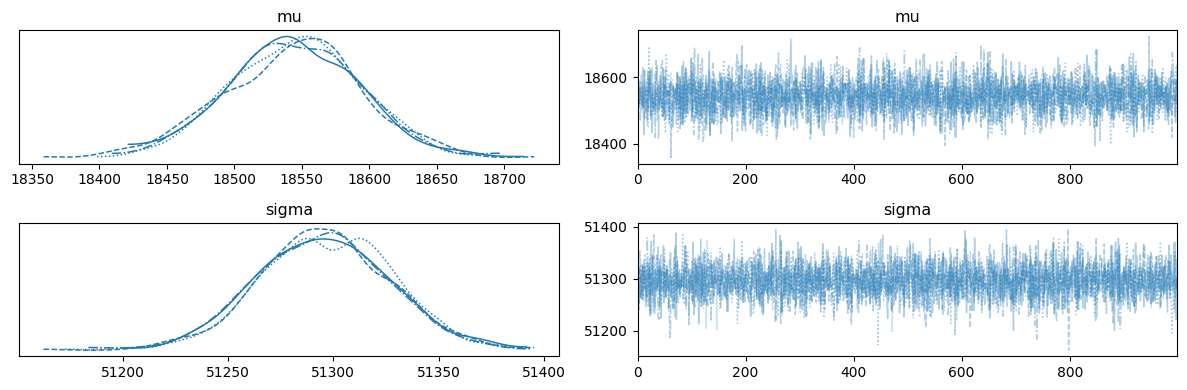

In [24]:
# Calculate KL Divergence with Normal distribution *
# Get mean posterior values
mu_nuts = float(trace.posterior["mu"].mean())
sigma_nuts = float(trace.posterior["sigma"].mean())
mu_advi = float(approx_sample.posterior["mu"].mean())
sigma_advi = float(approx_sample.posterior["sigma"].mean())

print(f"\nPosterior Means:")
print(f"  NUTS: mu = {mu_nuts:.4f}, sigma = {sigma_nuts:.4f}")
print(f"  ADVI: mu = {mu_advi:.4f}, sigma = {sigma_advi:.4f}")

# Create evaluation points
x = np.linspace(0, np.percentile(filtered_tcp, 99), 1000)
try:
    normal_nuts = stats.norm.pdf(x, loc=mu_nuts, scale=sigma_nuts)
    valid_nuts = True
except:
    print("Error calculating NUTS PDF - using fallback")
    valid_nuts = False
try:
    normal_advi = stats.norm.pdf(x, loc=mu_advi, scale=sigma_advi)
    valid_advi = True
except:
    print("Error calculating ADVI PDF - using fallback")
    valid_advi = False

# Plot comparison (only plot valid distributions)
plt.figure(figsize=(10, 6))
plt.hist(filtered_tcp, bins=50, density=True, alpha=0.5, label='Empirical')
if valid_nuts:
    plt.plot(x, normal_nuts, 'r-', linewidth=2, label=f'NUTS: Normal(μ={mu_nuts:.4f}, σ={sigma_nuts:.4f})')
if valid_advi:
    plt.plot(x, normal_advi, 'g-', linewidth=2, label=f'ADVI: Normal(μ={mu_advi:.4f}, σ={sigma_advi:.4f})')

plt.title("Normal Distribution Fit Comparison")
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("normal_comparison.png")
plt.close()

# Calculate KL divergence
hist, bin_edges = np.histogram(filtered_tcp, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
print("\nKL Divergence (lower is better):")
def calculate_kl(hist, theoretical_pdf):
    # Add epsilon to avoid zeros
    epsilon = 1e-10
    p = hist + epsilon
    q = theoretical_pdf + epsilon
    # Normalize to ensure proper probability distributions
    p = p / np.sum(p)
    q = q / np.sum(q)
    # KL divergence
    valid_indices = (p > 0) & (q > 0) & np.isfinite(p) & np.isfinite(q)
    if np.sum(valid_indices) == 0:
        return float('nan')
    p_valid = p[valid_indices]
    q_valid = q[valid_indices]
    return np.sum(p_valid * np.log(p_valid / q_valid))

if valid_nuts:
    normal_nuts_prob = stats.norm.pdf(bin_centers, loc=mu_nuts, scale=sigma_nuts)
    kl_nuts = calculate_kl(hist, normal_nuts_prob)
    print(f"  Empirical vs Normal (NUTS): {kl_nuts:.6f}")
else:
    print("  NUTS KL calculation failed")
    kl_nuts = float('inf')

if valid_advi:
    normal_advi_prob = stats.norm.pdf(bin_centers, loc=mu_advi, scale=sigma_advi)
    kl_advi = calculate_kl(hist, normal_advi_prob)
    print(f"  Empirical vs Normal (ADVI): {kl_advi:.6f}")
else:
    print("  ADVI KL calculation failed")
    kl_advi = float('inf')

# Determine which method is better
if np.isfinite(kl_nuts) and np.isfinite(kl_advi):
    better = "NUTS" if kl_nuts < kl_advi else "ADVI"
    print(f"  Better fit: {better}")
elif np.isfinite(kl_nuts):
    print("  Better fit: NUTS (ADVI calculation failed)")
elif np.isfinite(kl_advi):
    print("  Better fit: ADVI (NUTS calculation failed)")
else:
    print("  Both KL calculations failed")

az.plot_trace(trace)
plt.tight_layout()